# PREVISÃO DOS DISPAROS DE UM SISTEMA DE ALARME UTILIZANDO MACHINE LEARNING.

Um dos maiores causadores de custos para as empresas de monitoramento são os deslocamentos, ou seja, quando a empresa precisa enviar uma viatura (carro ou moto) até a residência ou comércio que está sendo monitorado.

Acontece que muitas vezes esses disparos são causados por cenários diversos, como: um galho de arvore balançando ao vento, tempestades, animais, ou mesmo pelo próprio cliente querendo fazer um teste para ver se a empresa de monitoramento está mesmo de olho.

Baseado neste fato foi elaborado o modelo de machine learning para indicar a probabilidade de o disparo ser falso ou verdadeiro.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Os dados

Vamos começar lendo os arquivos train e test em um DataFrame pandas.

In [2]:
df = pd.read_csv('train.csv',sep=";")
df.head()

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento,Confirmado
0,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:12.497,E131,1
1,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:17.440,E131,1
2,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:27.303,E131,1
3,11794,4,0,0,SP,SAO CARLOS,PARQUE SANTA MONICA,2019-01-01 00:12:09.100,E130,0
4,9658,5,1,0,SP,SAO CARLOS,CENTRO,2019-01-01 00:36:35.657,E131,1


In [3]:
dftest = pd.read_csv('test.csv',sep=";")
dftest.head()

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento
0,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:13.623,E130
1,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:21.167,E130
2,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:28.617,E130
3,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:36.127,E130
4,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:42.813,E130


# Análise exploratória dos dados

Vamos começar algumas análises de dados exploratórios. Começaremos por verificar os dados que faltam.



In [4]:
#dados ausentes
df.isnull().sum()

Código Cliente                               0
Nível de risco                               0
Possui servidor CFTV                         0
Pessoa Física, Jurídica, ou Órgão Público    0
Estado                                       0
Cidade                                       0
Bairro                                       0
Data/hora                                    0
Código do evento                             0
Confirmado                                   0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Código Cliente                               1000 non-null int64
Nível de risco                               1000 non-null int64
Possui servidor CFTV                         1000 non-null int64
Pessoa Física, Jurídica, ou Órgão Público    1000 non-null int64
Estado                                       1000 non-null object
Cidade                                       1000 non-null object
Bairro                                       1000 non-null object
Data/hora                                    1000 non-null object
Código do evento                             1000 non-null object
Confirmado                                   1000 non-null int64
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


Antes de analisarmos quais as características mais se relacionam com a coluna "Confirmado" vamos separar a variável Hora na coluna "Data/hora" pois o horário pode ter uma relação forte com o evento confirmado.

In [6]:
df[['Data','Hora']] = df['Data/hora'].str.split(expand=True) 

In [7]:
df[['ano','mes','dia']] = df['Data'].str.split(expand=True,pat='-') 

In [8]:
df[['hora','min','seg']] = df['Hora'].str.split(expand=True,pat=':') 

In [9]:
df.head()

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento,Confirmado,Data,Hora,ano,mes,dia,hora,min,seg
0,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:12.497,E131,1,2019-01-01,00:02:12.497,2019,01,01,00,02,12.497
1,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:17.440,E131,1,2019-01-01,00:02:17.440,2019,01,01,00,02,17.440
2,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:27.303,E131,1,2019-01-01,00:02:27.303,2019,01,01,00,02,27.303
3,11794,4,0,0,SP,SAO CARLOS,PARQUE SANTA MONICA,2019-01-01 00:12:09.100,E130,0,2019-01-01,00:12:09.100,2019,01,01,00,12,09.100
4,9658,5,1,0,SP,SAO CARLOS,CENTRO,2019-01-01 00:36:35.657,E131,1,2019-01-01,00:36:35.657,2019,01,01,00,36,35.657


Como próximo passo, optou-se por retirar a letra do "Código do evento" para que possamos trabalhar esta coluna como um valor numérico, facilitando o trabalho do modelo de machine learning:

In [10]:
df['Código do evento']=df['Código do evento'].str.slice(start=1)

In [11]:
#verificando a quantidade de diferentes estados
df['Estado'].value_counts()

SP    1000
Name: Estado, dtype: int64

Feito isso, vamos agora retirar as colunas que não são relevantes para o resultado "Confirmado". Como o Estado das ocorrências é somente SP, podemos desconsidera-lo. Outras variáveis serão retiradas como "Data/hora",'Estado','Data','Hora','ano','mes','dia','min','seg','Cidade'. No anuncio do problema cita que o cliente pode ser o agente causador do disparo do alarme, além disso os bairros também podem ter influência nos eventos, porém os clientes e os bairros em um dataset podem não ser os mesmos em um outro dataset. Pensando nisso optou-se pela retirada dessas colunas. 

In [12]:
df.drop(['Data/hora','Estado','Data','Hora','ano','mes','dia','min','seg','Cidade','Bairro','Código Cliente'],axis=1,inplace=True)

In [13]:
df.head()

,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Código do evento,Confirmado,hora
0,5,0,0,131,1,00
1,5,0,0,131,1,00
2,5,0,0,131,1,00
3,4,0,0,130,0,00
4,5,1,0,131,1,00


## Análise Gráfica

Abaixo tem-se o gráfico indicando o número de eventos confirmados e não confirmados. Pode-se observar que o valor "0" é bem mais volumoso do que o "1".

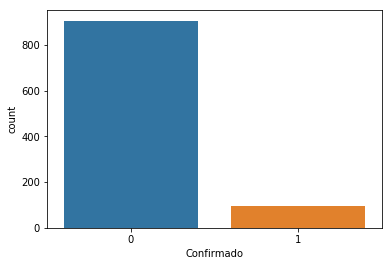

In [14]:
sns.countplot(x='Confirmado',data=df)

Vamos analisar agora a relação das "horas" com a variável "Confirmado". 

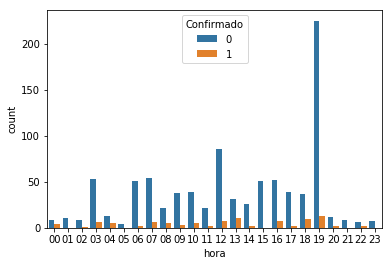

In [15]:
sns.countplot(x='hora',hue='Confirmado',data=df)

Abaixo o gráfico sobre o "Nível de risco". Tem-se que o nível de risco 3 e 4 estão bem mais presentes para Confirmado=0 do que Confirmado=1

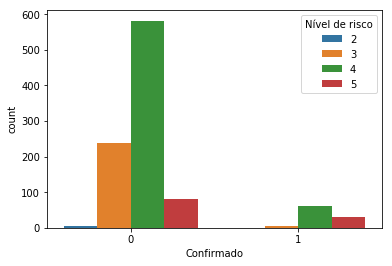

In [16]:
sns.countplot(x='Confirmado',hue='Nível de risco',data=df)

No gráfico abaixo tem-se que a variável "Possui servidor CFTV"=0 apresenta uma porcentagem bem mais alta para "confirmado"=0 do se comparado com "confirmado"=1

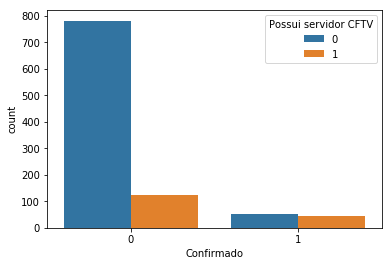

In [17]:
sns.countplot(x='Confirmado',hue='Possui servidor CFTV',data=df)

Analisando abaixo a variável 'Pessoa Física, Jurídica, ou Órgão Público' temos que o resultado 2 não aparece para confirmado=0

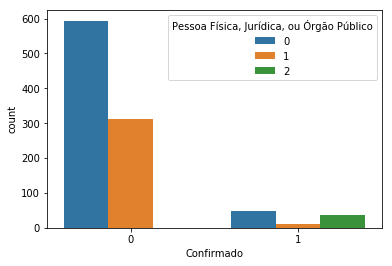

In [18]:
sns.countplot(x='Confirmado',hue='Pessoa Física, Jurídica, ou Órgão Público',data=df)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
Nível de risco                               1000 non-null int64
Possui servidor CFTV                         1000 non-null int64
Pessoa Física, Jurídica, ou Órgão Público    1000 non-null int64
Código do evento                             1000 non-null object
Confirmado                                   1000 non-null int64
hora                                         1000 non-null object
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [20]:
#df['hora'] = df['hora'].astype(int)

# Construindo um modelo de Regressão Logística

Como temos um conjunto de dados "train" na qual já se sabe a saída correta, dada pela coluna "Confirmado", devemos utilizar um modelo de aprendizagem supervisionada. Por se tratar de classificação entre confirmado ou não, "1" ou "0", 
optou-se pelo algoritmo de regressão logistica, já que este fornece a problabilidade de um evento ocorrer ou não atendendo o solicitado pelo problema.



## Divisão treino-teste

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes:

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Confirmado',axis=1), 
                                                    df['Confirmado'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

Vamos agora aplicar o modelo de Regressão Logistica:

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Fazendo a previsão nos dados de teste:

In [25]:
predictions = logmodel.predict(X_test)

## Avaliação

Vamos agora comparar os resultados previstos nos dados de teste (predictions) com os resultados reais já conhecidos deste (y_test) e analisar a assertividade do modelo.

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       276
          1       1.00      0.29      0.45        24

avg / total       0.95      0.94      0.93       300



Conseguimos uma precisão em torno de 95%, sendo este um resultado muito bom

## Previsão no dataset "test"

Vamos agora realizar a previsão no dataset test.csv. Para isso temos que tratar os dados da mesma forma que tratamos o datset train.csv

In [28]:
dftest.head()

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento
0,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:13.623,E130
1,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:21.167,E130
2,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:28.617,E130
3,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:36.127,E130
4,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:42.813,E130


In [29]:
#conferindo dados ausentes
dftest.isnull().sum()

Código Cliente                               0
Nível de risco                               0
Possui servidor CFTV                         0
Pessoa Física, Jurídica, ou Órgão Público    0
Estado                                       0
Cidade                                       0
Bairro                                       0
Data/hora                                    0
Código do evento                             0
dtype: int64

In [30]:
#retirando espaços em branco dos lados direito e esquerdo dos nomes das colunas
dftest.columns = [x.strip() for x in dftest.columns]

In [31]:
#separando as horas
dftest[['Data','Hora']] = dftest['Data/hora'].str.split(expand=True) 

In [32]:
dftest[['ano','mes','dia']] = dftest['Data'].str.split(expand=True,pat='-') 

In [33]:
dftest[['hora','min','seg']] = dftest['Hora'].str.split(expand=True,pat=':') 

In [34]:
dftest['Código do evento']=dftest['Código do evento'].str.slice(start=1)

In [35]:
#retirando colunas não utilizadas
dftest.drop(['Data/hora','Estado','Data','Hora','ano','mes','dia','min','seg','Cidade','Bairro','Código Cliente'],axis=1,inplace=True)

In [36]:
dftest.head()

,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Código do evento,hora
0,4,1,2,130,19
1,4,1,2,130,19
2,4,1,2,130,19
3,4,1,2,130,19
4,4,1,2,130,19


In [37]:
#dftest['hora'] = dftest['hora'].astype(int)

Preparado o dadaset "dftest", vamos treinar novamente o modelo de regressão logística agora utilizando todo o dataset de df (train.csv):

In [38]:
dfx=df.drop('Confirmado',axis=1)
dfy=df['Confirmado']

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
logmodel = LogisticRegression()
logmodel.fit(dfx,dfy)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Fazendo a previsão no dftest:

In [41]:
predictions = logmodel.predict(dftest)

Adicionando os resultados na coluna "confirmado"

In [42]:
dftest['Confirmado']=predictions

In [43]:
dftest.head()

,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Código do evento,hora,Confirmado
0,4,1,2,130,19,0
1,4,1,2,130,19,0
2,4,1,2,130,19,0
3,4,1,2,130,19,0
4,4,1,2,130,19,0


Analisando e comparando os resultados com o dataset train:

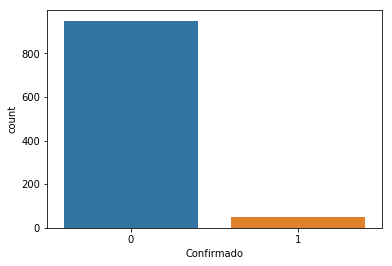

In [44]:
sns.countplot(x='Confirmado',data=dftest)

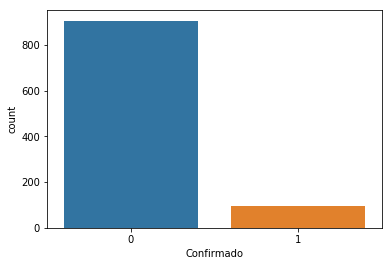

In [45]:
sns.countplot(x='Confirmado',data=df)

Pelos gráficos temos que a proporção de "0" e "1" dos dados previstos(dftest) é próxima dos dados de treino (df)

# The End - That's all Folks